In [2]:
## Run when initialise the code
import os

import geopandas as gpd
import osmnx as ox
from geopandas import GeoDataFrame, GeoSeries
from osmnx import io
import glob
import pickle
project_crs = 'epsg:3857'
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point, LineString, MultiPolygon, MultiPoint
import math
import warnings
import pandas as pd
import shutil
from tqdm import tqdm
import time

warnings.filterwarnings(action='ignore')
from momepy import remove_false_nodes, extend_lines

pjr_loc = os.path.dirname(os.getcwd())
import ast  # to convert str with list to list of string

In [3]:
## Choose locations and create folders if necessary

place = 'Turin'
print(place)
data_folder  = f'{pjr_loc}/places/{place.replace(",","_").replace(" ","_")}_test'
os.makedirs(f'{data_folder}/delete_2_nodes',exist_ok = True)
os.makedirs(f'{data_folder}/split_tp_intersection',exist_ok = True)
if place =='Tel Aviv':
    useful_tags_path = ['name:en','highway','length','bearing','tunnel','junction']
    ox.utils.config(useful_tags_way=useful_tags_path)


Turin


In [ ]:
# Download data
graph = ox.graph_from_place(place, network_type='all')
graph = ox.bearing.add_edge_bearings(graph, precision=1)
graph_pro = ox.projection.project_graph(graph, to_crs=project_crs)
io.save_graph_geopackage(graph_pro, filepath=f'{data_folder}/osm_data.gpkg', encoding='utf-8', directed=False)

In [4]:
## Filter out polylines and calculate angles
my_gdf = gpd.read_file(f'{data_folder}/osm_data.gpkg',
                       layer='edges')  # Identify roundabout elements, if any exist, and store them in a separate DataFrame.
if place =='Tel Aviv':
    my_gdf.rename(columns={'name:en':'name'}, inplace=True)

is_junction = True if 'junction' in my_gdf.columns else False
if is_junction:
    round_about = my_gdf[my_gdf['junction'].isin(['roundabout', 'circular'])]
    my_gdf = my_gdf[~((my_gdf['junction'] == 'roundabout') | (my_gdf['junction'] == 'circular'))]
to_remove = my_gdf[~((my_gdf['highway'] == 'motorway') | (my_gdf['highway'] == 'trunk')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'motorway_link')| (my_gdf['highway'] == 'trunk_link'))]
# Eliminate polylines that lack a name and calculate angles ranging from 0 to 180 degrees based on the bearing field.
df_pro = to_remove.to_crs(project_crs).dropna(subset=['name'])
df_pro = df_pro[df_pro['name']!='']
df_pro['angle'] = df_pro['bearing'].apply(lambda x: x if x < 180 else x - 180)
df_pro['length'] = df_pro.length

 # Function to convert valid list strings to lists
def convert_to_list(s):
    try:
        return ast.literal_eval(s)[0]
    except (ValueError, SyntaxError,TypeError):
        return s  # Return the original string if conversion fails

# Apply the function to the DataFrame column so polylines with several street names will return the first name.
df_pro['name'] = df_pro['name'].apply(convert_to_list)

In [5]:
# NEW CODE
df_pro['highway'] = df_pro['highway'].apply(convert_to_list)

In [6]:
# Detect multi lanes' scenario
# DBSCAN and first initial filtering
# group the street segments by street name
my_groupby = df_pro.groupby('name')
dic_final = {'name': [], 'geometry': [], 'highway': [], 'bearing': [], 'group': [],'is_simplified':[]}
name = 'Corso Orbassano'
res = my_groupby.get_group(name)
res = res.dropna(subset=['angle'], axis=0)
if len(res) < 2:
    data = res
    _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
# Use DBSCAN to classify streets based on their angle, and group each class. Outliers could not consider parallel with any street, thus removed
res['group'] = DBSCAN(eps=10, min_samples=2).fit(res['angle'].to_numpy().reshape(-1, 1)).labels_
# if all is -1, don't touch the element
if (res['group']== -1).all():
    data = res
    _  = res['geometry'].apply(lambda x:update_df_with_center_line(x))
# check parallelism for one street. We create buffer around each polyline and also translate the buffer. If 10% of at least  one of  the translated polylines is overlay with the buffer it is multi lanes  scenarios
angels_groups = res.groupby('group')
data  = angels_groups.get_group(0)
data.explore()

In [7]:
to_translate = data.copy()
my_buffer = to_translate['geometry'].buffer(cap_style=2, distance=30, join_style=3)
to_translate['geometry'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'right'))
my_s_join = to_translate
the_buffer= my_buffer.copy()
# If there is overlay
new_data_0 = my_s_join.sjoin(GeoDataFrame(geometry=the_buffer, crs=project_crs), how='inner').reset_index()
if not len(new_data_0):
    print('return -1')
new_data_1= new_data_0[new_data_0['index'] != new_data_0['index_right']] # Remove overlay of polylines with its buffer
flag= True
for translated_line in new_data_1.iterrows():
    translated_line = translated_line[1]
    geo_tr_line =GeoDataFrame(data= pd.DataFrame([translated_line]),crs=project_crs)
    overlay = gpd.overlay(geo_tr_line, GeoDataFrame(geometry=the_buffer.loc[geo_tr_line['index_right']], crs=project_crs), how='intersection')
    if (overlay.length/translated_line.length).iloc[0]*100>10:
        print('return 1')
        flag = False
        break
if flag:
    print('return 0')

return 1


In [8]:
# Functions and classes to be utilized - Module 3
def update_list(line_local):
    """
    add the first start/end point into the list
    :param line_local:
    :return:
    """
    list_pnts_of_line_group.extend([Point(line_local.coords[0]), Point(line_local.coords[-1])])
def create_center_line(one_poly):
    """
    This method calculate new line between the farthest points of the simplified polygon
    :param one_poly:
    :return:
    """

    pnt_list = one_poly.exterior.coords[:-1]
    list_shp = [Point(item) for item in pnt_list]
    dis, dis_2, dis_3 = 0, 0, 0
    third_dis = (-1, -1)
    # The new line will be determined by the third-farthest points
    for k, point in enumerate(list_shp):
        j = k
        for point2 in list_shp[k + 1:]:
            j += 1
            temp_dis = point.distance(point2)
            if temp_dis > dis:
                dis = point.distance(point2)
            elif temp_dis > dis_2:
                dis_2 = point.distance(point2)
            elif temp_dis > dis_3:
                third_dis = (k, j)
                dis_3 = point.distance(point2)
    max_dist['name'].extend([id_pol + 2, id_pol + 2])
    max_dist['geometry'].extend([list_shp[third_dis[0]], list_shp[third_dis[1]]])
def add_more_pnts_to_new_lines(pnt_f_loc: Point, pnt_l_loc: Point, line_pnts: list, angl_rng: float ) -> list:
    """
    This method checks if more points should be added to the new lines by checking along the new line if the distance to the old network roads are more than 10 meters
    :param angl_rng: # Used latter to find how many checks should be done
    :return:
    """
    # Calculate distance and azimuth between the first and last point
    dist = pnt_f_loc.distance(pnt_l_loc)
    x_0 = pnt_f_loc.coords[0][0]
    y_0 = pnt_f_loc.coords[0][1]
    bearing = math.atan2(pnt_l_loc.coords[0][0] - x_0, pnt_l_loc.coords[0][1] - y_0)
    bearing = bearing + 2 * math.pi if bearing < 0 else bearing
    # Calculate the number of  checks going to carry out
    # If the angel range is less than 1 degree the line will be based on the first and last points, otherwise use the following equation:
    if angl_rng <1:
        return line_pnts
    # With this equation,angl_rng equal to 1 the length_to_check is 50 and angl_rng equal to 179 the length_to_check is around 1 and change in the
    # length become smaller when angl_rng is begger
    length_to_check  =100 -math.log(50)*19
    print(length_to_check)
    loops = int(dist /length_to_check)
    print(loops)

    # Calculate  the first point over the line
    for dis_on_line in range(1, loops):
        x_new = x_0 + length_to_check  * dis_on_line * math.sin(bearing)
        y_new = y_0 + length_to_check  * dis_on_line * math.cos(bearing)
        # S_joins to all the network lines (same name and group)
        # if the distance is less than 10 meters continue, else: find the projection point and add it to the correct location and run the function agein
        one_pnt_df = GeoDataFrame(geometry=[Point(x_new, y_new)], crs=project_crs)
        s_join_loc = one_pnt_df.sjoin_nearest(data, distance_col='dis').iloc[0]
        if s_join_loc['dis'] > 10:
            pnt_med = s_join_loc['geometry']
            line = data.loc[s_join_loc['index_right']]['geometry']
            line_pnts.append(line.interpolate(line.project(pnt_med)))
            line_pnts = add_more_pnts_to_new_lines(pnt_med, pnt_l_loc, line_pnts,angl_rng)
            return line_pnts
    return line_pnts
def update_df_with_center_line(new_line,is_simplified=0,group_name= -1):
    """
    update our dictionary with new lines
    :param is_simplified:
    :param new_line:
    :param group_name: According to the DBSCAN algorithm, if no =-1
    :return:
    """
    dic_final['name'].append(name)
    # dic_final['geometry'].append(LineString(coordinates=(pnt_list[max_dis[0]], pnt_list[max_dis[1]])))
    dic_final['geometry'].append(new_line)
    dic_final['highway'].append(data.iloc[0]['highway'])
    dic_final['bearing'].append(data['angle'].mean())
    dic_final['group'].append(group_name)
    dic_final['is_simplified'].append(is_simplified)

In [9]:
# NEW CODE #
min_num_of_polylines = len(data)/10
# Use a single boolean condition for filtering
condition = (data['highway'].isin(['service','unclassified'])) & (data.groupby('highway')['highway'].transform('count') >= min_num_of_polylines)
data = data[~condition]

In [10]:
# Define the first line
# if among of lines with same angles some are parallel:
# new points DataFrame of start/end line of each group
list_pnts_of_line_group = []
data['geometry'].apply(update_list)
df_pnts = GeoDataFrame(geometry=list_pnts_of_line_group, crs=project_crs).drop_duplicates()

# unify lines to one polygon
buffers = data.buffer(cap_style=3, distance=30, join_style=3)
one_buffer = buffers.unary_union

max_dist = {'name': [], 'geometry': []}

In [68]:
# NEW CODE

points = one_buffer[0].exterior.coords[:-1]
num_points = len(points)
distances= []
angles= []
for i in range(num_points):
    point1 = Point(points[i])
    for j in range(i + 1, num_points):
        point2 = Point(points[j])

        # Calculate angle (range between 0 and 180)
        angle = math.degrees(math.atan2(point2.y - point1.y, point2.x - point1.x))
        if angle < 0:
            angle += 180

        # Calculate distance
        distance = point1.distance(point2)
angle

159.45815036260964

In [11]:
from itertools import combinations
point_combinations = list(combinations(one_buffer[0].exterior.coords[:-1], 2))
point_combinations

[((847508.1139837552, 5626503.414345579),
  (847518.0382743053, 5626518.301437017)),
 ((847508.1139837552, 5626503.414345579),
  (847534.42450335, 5626521.262743511)),
 ((847508.1139837552, 5626503.414345579),
  (847560.4223202205, 5626512.958157428)),
 ((847508.1139837552, 5626503.414345579),
  (847574.1383856565, 5626515.82626434)),
 ((847508.1139837552, 5626503.414345579),
  (847574.141599664, 5626515.810894085)),
 ((847508.1139837552, 5626503.414345579),
  (847575.5968176272, 5626516.114667436)),
 ((847508.1139837552, 5626503.414345579),
  (847576.8749538407, 5626516.352696634)),
 ((847508.1139837552, 5626503.414345579),
  (847644.8981286396, 5626527.501445247)),
 ((847508.1139837552, 5626503.414345579),
  (847667.9022372349, 5626538.72581155)),
 ((847508.1139837552, 5626503.414345579),
  (847671.1040729632, 5626532.1637148755)),
 ((847508.1139837552, 5626503.414345579),
  (847677.8366533044, 5626533.482866217)),
 ((847508.1139837552, 5626503.414345579),
  (847683.3784159528, 56265

In [ ]:
df_test= pd.DataFrame()
df_test['point_1'] = [Point(pair[0]) for pair in point_combinations]
df_test['point_2'] = [Point(pair[1]) for pair in point_combinations]

In [18]:
df_test['dist'] = df_test.apply(lambda x:x['point_1'].distance(x['point_2']),axis=1)
df_test['ratio_dist'] = df_test['dist']/df_test['dist'].max()

In [ ]:
def calc_az(row):
    # Calculate angle (range between 0 and 180)
    angle = math.degrees(math.atan2(row['point_2'].y - row['point_1'].y, row['point_2'].x - row['point_1'].x))
    if angle < 0:
        angle += 180
        return angle
    return angle
df_test['angle'] = df_test.apply(calc_az,axis=1)
avg= df_test['angle'].mean()
avg= df_test['angle'].mean()
avg= df_test['angle'].mean()

In [22]:
avg

39.26069273881235

In [26]:
min_ang= df_test['angle'].min()
max_ang= df_test['angle'].max()
print(f'min:{min_ang}, max:{max_ang}')
df_test['ratio_angle']= 1-abs(df_test['angle']-avg)/(max_ang- min_ang)
df_test['ratio'] = df_test['ratio_angle']+df_test['ratio_dist']
df_test

min:0.00046265224585795295, max:179.99624822327544


,point_1,point_2,dist,angle,ratio_dist,ratio_angle,ratio
0,POINT (847508.1139837552 5626503.414345579),POINT (847518.0382743053 5626518.301437017),17.891815,56.311097,0.003207,0.905273,0.908480
1,POINT (847508.1139837552 5626503.414345579),POINT (847534.42450335 5626521.262743511),31.793219,34.151986,0.005698,0.971618,0.977316
2,POINT (847508.1139837552 5626503.414345579),POINT (847560.4223202205 5626512.958157428),53.171857,10.340050,0.009530,0.839326,0.848856
3,POINT (847508.1139837552 5626503.414345579),POINT (847574.1383856565 5626515.82626434),67.180930,10.646767,0.012040,0.841030,0.853070
4,POINT (847508.1139837552 5626503.414345579),POINT (847574.141599664 5626515.810894085),67.181251,10.633378,0.012040,0.840956,0.852996
...,...,...,...,...,...,...,...
155398,POINT (847439.5733811407 5626534.7190728495),POINT (847488.1558766391 5626510.489537903),54.289310,153.493203,0.009730,0.365360,0.375090
155399,POINT (847439.5733811407 5626534.7190728495),POINT (847503.2421120217 5626504.836462622),70.332622,154.857215,0.012605,0.357782,0.370387
155400,POINT (847474.2953102988 5626517.012888834),POINT (847488.1558766391 5626510.489537903),15.318923,154.796401,0.002745,0.358120,0.360865
155401,POINT (847474.2953102988 5626517.012888834),POINT (847503.2421120217 5626504.836462622),31.403546,157.186021,0.005628,0.344844,0.350472


In [99]:
abs( df_test['angle'])

TypeError: 'Series' object is not callable

In [ ]:

# simplify polygon with simplify function. If one_buffer is multipolygon object simplify each one them separately
if isinstance(one_buffer, MultiPolygon):
    for id_pol, polygon in enumerate(one_buffer):
        create_center_line(polygon)
else:
    id_pol = -1
    create_center_line(one_buffer)
max_df = GeoDataFrame(max_dist, crs=project_crs)


In [63]:
# Add more vertices for the line
test= []

# max_df.to_file(f'{smplfcton_fldr}/simplimax_df.shp')
# find for each points the closet point from the oribinal data. the closet points will create the new line
s_join = max_df.sjoin_nearest(df_pnts).groupby('name')
for geo in s_join:
    same_name = geo[1]
    if same_name.iloc[0]['index_right'] == same_name.iloc[1]['index_right']:
        continue
    in_0 = same_name.iloc[0]['index_right']
    in_1 = same_name.iloc[1]['index_right']
    # These points will be served to be initial reference in order to find more points
    pnt_f = df_pnts.loc[in_0]['geometry']
    pnt_l = df_pnts.loc[in_1]['geometry']
    lines_pnt_geo = add_more_pnts_to_new_lines(pnt_f, pnt_l, [pnt_f],data['angle'].max() - data['angle'].min())
    lines_pnt_geo.append(pnt_l)
    # Update dic_final
    test.append(LineString(lines_pnt_geo))

25.671562896865225
214
25.671562896865225
211
25.671562896865225
210
25.671562896865225
209
25.671562896865225
208
25.671562896865225
207
25.671562896865225
206
25.671562896865225
204
25.671562896865225
203
25.671562896865225
202
25.671562896865225
201
25.671562896865225
200
25.671562896865225
199
25.671562896865225
198
25.671562896865225
197
25.671562896865225
196
25.671562896865225
195
25.671562896865225
194
25.671562896865225
193
25.671562896865225
192
25.671562896865225
191
25.671562896865225
190
25.671562896865225
189
25.671562896865225
188
25.671562896865225
187
25.671562896865225
186
25.671562896865225
185
25.671562896865225
184
25.671562896865225
183
25.671562896865225
182
25.671562896865225
181
25.671562896865225
180
25.671562896865225
179
25.671562896865225
178
25.671562896865225
177
25.671562896865225
176
25.671562896865225
175
25.671562896865225
174
25.671562896865225
173
25.671562896865225
172
25.671562896865225
171
25.671562896865225
170
25.671562896865225
169
25.67156289

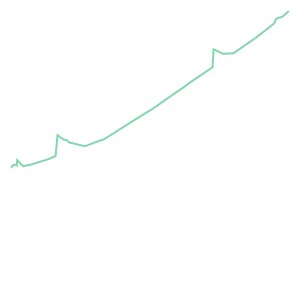

In [64]:
test[0]

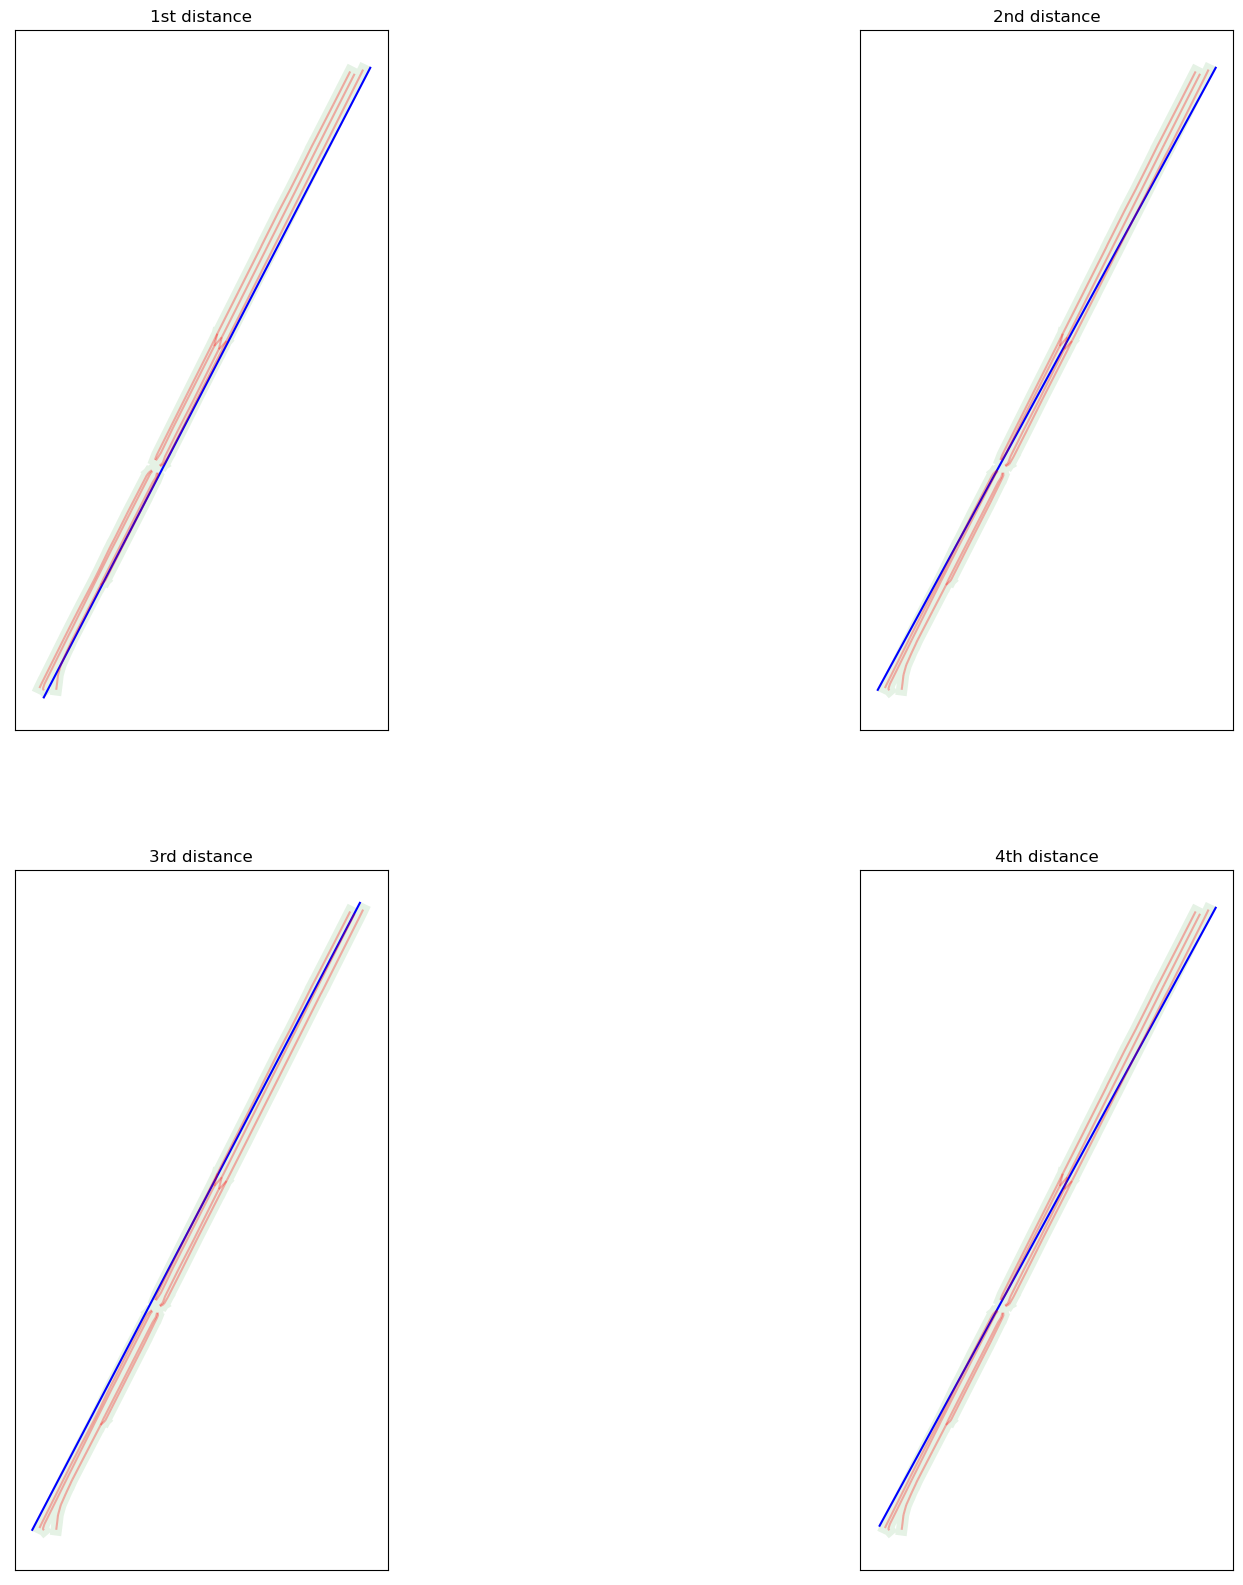

In [268]:
# For drawing
import geopandas as gpd
num_names = ['st','nd','rd','th']
import matplotlib.pyplot as plt
k=0

# Create a figure and four subplots
fig, axs = plt.subplots(2, 2, figsize=(20,20))
# fig.subplots_adjust(wspace=0.01, hspace=0.1)
for i in range(2):
    for j in range(2):
        # Plot the first layer
        max_df[k].plot(ax=axs[i, j], color='blue', alpha=1)
        # Add the second layer to the existing plot
        data.plot(ax=axs[i, j], color='red', alpha=0.3)
        GeoSeries(one_buffer,crs=project_crs).plot(ax=axs[i, j], color='green', alpha=0.1)
        axs[i, j].set_title(f'{k+1}{num_names[k]} distance')
        k+=1


# Remove ticks from all subplots
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
# Turn off the axis

plt.show()

In [31]:
# test intersection - update names
# Start from here
with open(f'{data_folder}/intersection/network_2.pkl', "rb") as f:
    df1= pickle.load(f)
with open(f'{data_folder}/intersection/extend_lines_f.pkl', "rb") as f:
    org_gpd= pickle.load(f)

# Split df1 into two GeoDataFrames: df3 (with names) and df4 (without names)
df3 = df1[df1['name'].notna()]
# df3.to_file(f'{data_folder}/delete_2_nodes/with_name.shp')
df4 = df1[df1['name'].isna()]
# df4.reset_index().to_file(f'{data_folder}/delete_2_nodes/no_name_init.shp')

# use only one polyline from the original dataframe for name even if the algorithm may found more
old_index  ='old_index'

df = gpd.sjoin(df4, org_gpd).reset_index(names='old_index')
# Create a new dictionary to store the updated data.
dic_str_data = {}
# Define the relevant columns to store
rel_col  =[col for col in df.columns if col.endswith("right")]+['geometry']
rel_col.remove('index_right')

# nore code should be added here to update name